In [ ]:
import torch
import sys
import os
from __future__ import print_function, division
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
from skimage.transform import resize
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as ff
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Set device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
prefix = '/content/gdrive/My Drive/'
# modify "customized_path_to_your_project" 
customized_path_to_your_project = 'AML/Project/'
sys_path = os.path.join(prefix, customized_path_to_your_project)
sys.path.append(sys_path)
print(f"System path: {sys_path}")

System path: /content/gdrive/My Drive/AML/Project/


In [ ]:
# reading the CSV file with driver-class mapping for training
root_dir = sys_path+"Coding"
driver_imgs_csv = sys_path+"Coding/CSV/driver_imgs_list.csv"

print("Root directory Location: {}".format(root_dir)+"\n")
print("CSV file Location: {}".format(driver_imgs_csv)+"\n")


drivers_imgs_file = pd.read_csv(driver_imgs_csv)
print(drivers_imgs_file)

n=0
img_name=drivers_imgs_file.iloc[n,2]
img_class=drivers_imgs_file.iloc[n,1]
print("Image name: {}".format(img_name))
print("Image class: {}".format(img_class[1]))


Root directory Location: /content/gdrive/My Drive/AML/Project/Coding

CSV file Location: /content/gdrive/My Drive/AML/Project/Coding/CSV/driver_imgs_list.csv

      subject classname            img
0        p002        c0  img_44733.jpg
1        p002        c0  img_72999.jpg
2        p002        c0  img_25094.jpg
3        p002        c0  img_69092.jpg
4        p002        c0  img_92629.jpg
...       ...       ...            ...
22419    p081        c9  img_56936.jpg
22420    p081        c9  img_46218.jpg
22421    p081        c9  img_25946.jpg
22422    p081        c9  img_67850.jpg
22423    p081        c9   img_9684.jpg

[22424 rows x 3 columns]
Image name: img_44733.jpg
Image class: 0


# Data loading

In [ ]:
# number of unique drivers in the dataset
unique_driver_list = list(drivers_imgs_file.iloc[:, 0][1:].unique())
print("Unique drivers are:", unique_driver_list)
print("Number of unique drivers:",len(unique_driver_list))

Unique drivers are: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Number of unique drivers: 26


In [ ]:
# Accessing the csv location of each unique driver
#print(root_dir)
unique_driver_csv_path=list()
for driver in unique_driver_list:
  driver_csv_path=root_dir+"/CSV/"+driver+".csv"
  unique_driver_csv_path.append(driver_csv_path)
print("CSV path of unique drivers:",unique_driver_csv_path, len(unique_driver_csv_path))

CSV path of unique drivers: ['/content/gdrive/My Drive/AML/Project/Coding/CSV/p002.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p012.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p014.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p015.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p016.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p021.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p022.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p024.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p026.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p035.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p039.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p041.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p042.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p045.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p047.csv', '/content/gdrive/My Drive/AML/Project/Coding/CSV/p049.csv', '/content/g

In [ ]:
'''
import random
drivers_val=random.sample(unique_driver_csv_path,5) # A list containing the file location of randomly choosen validation drivers
print("Drivers seleted for validation\n")
for i in range(len(drivers_val)):
  print("Driver name:",drivers_val[i][49:52],"---> Driver CSV location:",drivers_val[i])

print("\n")

drivers_train=list() # A list containing the file location of remaining drivers (used for testing)
print("Drivers selected for testing\n")
for j in unique_driver_csv_path:
  if j in drivers_val:
    continue
  else:
    drivers_train.append(j)
    print("Driver name:",j[49:52],"---> Driver CSV location:",j)
'''


In [ ]:
'''# combining CSV files for test set and validation set

# Training data
train_combined=pd.concat([pd.read_csv(f) for f in drivers_train])
train_combined.to_csv( "train_combined.csv", index=False, encoding='utf-8-sig')

# Validation data
val_combined=pd.concat([pd.read_csv(f) for f in drivers_val])
val_combined.to_csv( "val_combined.csv", index=False, encoding='utf-8-sig')'''


In [ ]:
class DistractedDriverDataset(Dataset): # custom class to explore the dataset 

  def __init__(self, csv_file_loc, root_dir, transform=None):
    self.driver_imgs_file = pd.read_csv(csv_file_loc) #  reading the CSV file
    self.root_dir = root_dir # root directory of the images 
    self.transform = transform # transformations if any

  def __len__(self):  # returns the length of the entire training set
    return len(self.driver_imgs_file)

  def __getitem__(self, idx):    
    img_name=os.path.join(self.root_dir,self.driver_imgs_file.iloc[idx,1],self.driver_imgs_file.iloc[idx,2]) # featching the file name    
     
    driver_name=self.driver_imgs_file.iloc[idx,0] # driver name
    #print(img_name, driver_name)
    img_tensor=self.transform(Image.open(img_name)) # reading the image
    
    img_class=int(self.driver_imgs_file.iloc[idx,1][1])# fetching the image class 
    
    return img_tensor,img_class #,img_name[64:77],driver_name


In [ ]:
# Here we create two seperate instances of the Distracted driver data set. One will hold the data set for training and the other will hold data for validation

train_data_loc="/content/train_combined.csv" # location of the training csv file
val_data_loc="/content/val_combined.csv" # location of the validation csv file
print("Root directory:",root_dir,"\n")

train_dataset=DistractedDriverDataset(csv_file_loc=train_data_loc,root_dir=root_dir+"/Data/Train",
                                transform=transforms.Compose([transforms.RandomRotation(degrees=(-15,15)), transforms.Resize((244,244)), transforms.ToTensor()]))
len_train_dataset=len(train_dataset)
print("Total number of elements in training data:", len_train_dataset)


val_dataset=DistractedDriverDataset(csv_file_loc=val_data_loc,root_dir=root_dir+"/Data/Train",
                                transform=transforms.Compose([transforms.Resize((244,244)),transforms.ToTensor()]))
len_val_dataset=len(val_dataset)
print("Total number of elements in validation data:", len_val_dataset)

Root directory: /content/gdrive/My Drive/AML/Project/Coding 

Total number of elements in training data: 18661
Total number of elements in validation data: 3763


In [ ]:
# claculating the weights for each class

train_csv=pd.read_csv(train_data_loc)
train_csv.head()
count_list=train_csv.groupby('classname').size().to_list()
weights=list()
print(f"Counts for each class: {count_list}")
total=sum(count_list)
for count in count_list:
  w=max(count_list)/count
  weights.append(w)

weights=torch.FloatTensor(weights).to(device)
print(f"Training weights: {weights}")
  
  


Counts for each class: [2067, 1911, 1967, 1944, 1947, 1916, 1950, 1632, 1558, 1769]
Training weights: tensor([1.0000, 1.0816, 1.0508, 1.0633, 1.0616, 1.0788, 1.0600, 1.2665, 1.3267,
        1.1685], device='cuda:0')


In [ ]:
# loading training and validation data for the neural network
train_loader=DataLoader(train_dataset, batch_size=32,shuffle=True, num_workers=16) # x.shape--->torch.Size([32, 3, 244, 244])
val_loader=DataLoader(val_dataset, batch_size=32,shuffle=True, num_workers=16) # x.shape---> torch.Size([32, 3, 244, 244]) 

'''for x,y in train_loader:
  print(x.shape)
  x=x.squeeze()
  print(x.shape)
  plt.imshow(  x.permute(1, 2, 0)  )
  break'''

'''img=Image.open("/content/img_3509.jpg")
plt.imshow(img)'''

'img=Image.open("/content/img_3509.jpg")\nplt.imshow(img)'

#Helper functions

In [ ]:
# helper function for computing accuracy
def get_acc(pred, y):
  pred = pred.float()
  y = y.float() 
  return (y==pred).sum().float()/y.size(0)*100.
  

In [ ]:
def get_model_acc_and_loss(cal_loss,model,criterion,loader):      
  ys=[]
  y_preds=[]
  loss_total=0
  for x, y in loader:    
    x=x.to(device)
    y=y.to(device)
    y_pred=model(x)
    ys.append(y)
    y_preds.append(torch.argmax(y_pred, dim=1))

    if cal_loss==True:
      loss=criterion(y_pred,y)
      loss_total += loss.item()

  if cal_loss==True:    
    y=torch.cat(ys, dim=0)
    y_pred=torch.cat(y_preds, dim=0)
    return get_acc(y_pred, y), loss_total
  else:
    y=torch.cat(ys, dim=0)
    y_pred=torch.cat(y_preds, dim=0)
    return get_acc(y_pred, y) 
  
    

In [ ]:
# solver function for NN training
def Solver_NN (model, name, train_loader, val_loader, optim, criterion, len_train_dataset, len_val_dataset, epoch=51, lr=1e-1):
  print("Solver Initiated")
  model=model.to(device) # sending model to GPU
  print("Model successfully sent to the GPU\n")  

  train_acc_list=list()
  val_acc_list=list()
  epoch_list=list()
  train_loss_list=list()
  val_loss_list=list()
  total_step = len(train_loader)
  best_epoch=None
  #curr_lr = learning_rate
  counter=0
  for e in range(epoch):
    loss_epoch=0     
    epoch_list.append(e)   

    for i,(x,y) in enumerate(train_loader):      
      x = x.to(device)
      y = y.to(device)    
      #print("x is:",x.shape)     
      #print("y is:",y.shape)

      

      #forward pass
      y_pred=model(x)
      #print("y_pred is:",y_pred.shape)
      loss=criterion(y_pred,y)
      #print("loss:",loss)

      #bacward pass
      optim.zero_grad()
      #loss.to(device)
      loss.backward()
      optim.step()
      
      loss_epoch += float(loss.item())
      #print("loss epoch:",loss_epoch)    
         
      #print(f"Training loss in epoch {e} is {(loss_epoch/len_train_dataset)*1000}") 
      #train_loss_list.append((loss_epoch/len_train_dataset)*1000)

      if (i+1) % 100 == 0:
        print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(counter+1, epoch, i+1, total_step, loss.item()))
    counter+=1
      
    print(f"Training loss in epoch {e} is {(loss_epoch/len_train_dataset)*1000}") 
    train_loss_list.append((loss_epoch/len_train_dataset)*1000)

    with torch.no_grad():      
      val_acc, val_loss = get_model_acc_and_loss(True,model,criterion,val_loader)
      print(f"Validation loss in epoch {e} is {(val_loss/len_val_dataset)*1000}")
      val_loss_list.append((val_loss/len_val_dataset)*1000)
      train_acc = get_model_acc_and_loss(False,model,criterion,train_loader)
      train_acc_list.append(train_acc)
      val_acc_list.append(val_acc)
      print(f'Validation accuracy: {val_acc}, Train accuracy: {train_acc}') 

      if best_epoch==None:
        best_epoch=e        
        best_val=val_acc
        torch.save(model.state_dict(), root_dir+'/Saved Weights/'+name+" epoch "+str(e))
        print("File saved successfully\n")
      elif val_acc>best_val:
        best_epoch=e        
        best_val=val_acc
        torch.save(model.state_dict(), root_dir+'/Saved Weights/'+name+" epoch "+str(e))
        print("File saved successfully\n")
      else:
        print("\n")

  print(f'Best epoch:{best_epoch}, Best Validtion accuracy:{best_val}')

  fig, axs = plt.subplots(2)  
  fig.tight_layout(pad=3.0)
  axs[0].plot(epoch_list,train_acc_list, 'r--' ,epoch_list,val_acc_list,'g')
  axs[0].set_title('Accuracy vs. epochs')  
  axs[1].plot(epoch_list,train_loss_list, 'r--' ,epoch_list,val_loss_list,'g')
  axs[1].set_title('Loss vs. epochs')
  

  plt.savefig(name+".png")

  
  
  return model 

#Neural networks

In [ ]:
class CNNClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Construct a CNN with 2 layers of convolutional layer and 1 layer of linear layer.
        self.cnn= nn.Sequential(
                            nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2),
                            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(32, 64, kernel_size=3, stride=1),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2),
                            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2)
                           
                    )
        self.fc = nn.Linear(2304, 10)
    def forward(self, x):
        batch_size = x.size(0)
        return self.fc(self.cnn(x).view(batch_size, -1))

In [ ]:
class extra_layer(nn.Module):
    
    def __init__(self):
        super().__init__()               
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(1000, 512),
            nn.Linear(512, 10))
    def forward(self, x):        
        return self.fc(x)

#Model Evaluation

In [ ]:
# Instantiating one of the models given in Neural Network section

def select_model(inp,CNNClassifier, training, extra_layer):
  print(f"Pre trainined: {training}")
  if inp==1:
    model=CNNClassifier()
    name="CNN"
  elif inp==2:
    model=nn.Sequential(torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=training), extra_layer)
    name="VGG16"
  elif inp==3:
    model = nn.Sequential(torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=training), extra_layer)
    name="RESNET18"
  elif inp==4:
    model = nn.Sequential(torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=training), extra_layer)
    name="RESNET34"
  elif inp==5:
    model=nn.Sequential(torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=training), extra_layer)
    name="ALEXNET"
  elif inp==6:
    model=nn.Sequential(torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=training), extra_layer)
    name="MOBILENET_V2"
  return model, name 

print("-------------------Select Model----------------------")
print("Input '1' for CNNClassifier")
print("Input '2' for VGG16")
print("Input '3' for Resnet18")
print("Input '4' for Resnet34")
print("Input '5' for Alexnet")
print("Input '6' for Mobilenet_v2")
inp=int(input("Your input---> "))

if inp==2 or inp ==3 or inp ==4 or inp==5 or inp==6:
  train=int(input("Do you want a pretrained version 1/0? "))
  if train ==1:
    pretrained=True
  else:
    pretrained=False
print("-----------------------------------------------------------")

model, name=select_model(inp,CNNClassifier(),pretrained,extra_layer())
print(f"selected model---> {name}\n  {model}")

-------------------Select Model----------------------
Input '1' for CNNClassifier
Input '2' for VGG16
Input '3' for Resnet18
Input '4' for Resnet34
Input '5' for Alexnet
Input '6' for Mobilenet_v2
Your input---> 5
Do you want a pretrained version 1/0? 1
-----------------------------------------------------------
Pre trainined: True


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


selected model---> ALEXNET
  Sequential(
  (0): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0

In [ ]:
response=int(input("Do you want to load weights from previously saved mode to continue training 1/0 ?"))
if response==1:
  weights=str(input("Input the location of the pickle file"))
  model.load_state_dict(torch.load(weights))
elif response==0:
  print("No weights loaded")

Do you want to load weights from previously saved mode to continue training 1/0 ?0
No weights loaded


In [ ]:
#criterion and optimizer

lr=1e-2
criterion=nn.CrossEntropyLoss(reduction='mean', weight=weights) # loss criterion 
optim=torch.optim.SGD(model.parameters(), lr=lr) # optimizer 

In [ ]:
# GPU Access and model parameters
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print("Running on Cuda")
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable parameters:",params)

Running on Cuda
Learnable parameters: 61618482


Solver Initiated
Model successfully sent to the GPU

Epoch [1/10], Step [100/584] Loss: 1.8448
Epoch [1/10], Step [200/584] Loss: 0.9186
Epoch [1/10], Step [300/584] Loss: 0.7346
Epoch [1/10], Step [400/584] Loss: 0.3507
Epoch [1/10], Step [500/584] Loss: 0.3750
Training loss in epoch 0 is 32.70523492004316
Validation loss in epoch 0 is 27.069652505038807
Validation accuracy: 74.1429672241211, Train accuracy: 92.9853744506836
File saved successfully

Epoch [2/10], Step [100/584] Loss: 0.1764
Epoch [2/10], Step [200/584] Loss: 0.5081
Epoch [2/10], Step [300/584] Loss: 0.0789
Epoch [2/10], Step [400/584] Loss: 0.1841
Epoch [2/10], Step [500/584] Loss: 0.2377
Training loss in epoch 1 is 5.877901701160112
Validation loss in epoch 1 is 61.30125869185311
Validation accuracy: 53.36167907714844, Train accuracy: 70.56964111328125


Epoch [3/10], Step [100/584] Loss: 0.1915
Epoch [3/10], Step [200/584] Loss: 0.0148
Epoch [3/10], Step [300/584] Loss: 0.0209
Epoch [3/10], Step [400/584] Loss: 0.01

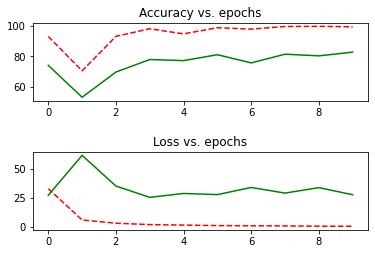

In [ ]:
#model training

modle=Solver_NN(model, name, train_loader, val_loader, optim,criterion, len_train_dataset, len_val_dataset, epoch=10, lr=lr)

##Evaluation

In [ ]:
# selecting and loading weights of a trainied models

def select_model(inp,CNNClassifier,extra_layer):
  
  if inp==1:
    model=CNNClassifier()
    name="CNN"
  elif inp==2:
    model=nn.Sequential(torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=False), extra_layer)
    name="VGG16"
  elif inp==3:
    model = nn.Sequential(torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False), extra_layer)
    name="RESNET18"
  elif inp==4:
    model = nn.Sequential(torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=False), extra_layer)
    name="RESNET34"
  elif inp==5:
    model=nn.Sequential(torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False), extra_layer)
    name="ALEXNET"
  elif inp==6:
    model=nn.Sequential(torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=False), extra_layer)
    name="MOBILENET_V2"
  return model, name 

print("-------------------Select Model----------------------")
print("Input '1' for CNNClassifier")
print("Input '2' for VGG16")
print("Input '3' for Resnet18")
print("Input '4' for Resnet34")
print("Input '5' for Alexnet")
print("Input '6' for Mobilenet_v2")
inp=int(input("Your input---> "))
print("-----------------------------------------------------------")

model, name=select_model(inp,CNNClassifier(),extra_layer())
model.to(device)
print(f"selected model---> {name}\n  {model}")


print("-------------------Load Weights---------------------")

loc=input(f"enter the location of pkl file for model {name}")
model.load_state_dict(torch.load(loc))


print("-----------------------------------------------------------")

-------------------Select Model----------------------
Input '1' for CNNClassifier
Input '2' for VGG16
Input '3' for Resnet18
Input '4' for Resnet34
Input '5' for Alexnet
Input '6' for Mobilenet_v2
Your input---> 5
-----------------------------------------------------------


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


selected model---> ALEXNET
  Sequential(
  (0): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0

In [ ]:
#criterion and optimizer

lr=1e-2
criterion=nn.CrossEntropyLoss(reduction='mean') # loss criterion 
optim=torch.optim.SGD(model.parameters(), lr=lr) # optimizer 

In [ ]:
with torch.no_grad():
  val_acc,val_loss = get_model_acc_and_loss(True, model, criterion, val_loader)
  print(f'Validation accuracy: {val_acc}, & Validation loss: {val_loss}')

Validation accuracy: 82.40765380859375, & Validation loss: 106.44418542087078
